In [58]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
# Import the presplit data
X_train = pd.read_csv('data/X_train.csv', index_col='id')
X_test = pd.read_csv('data/X_test.csv', index_col='id')
y_train = pd.read_csv('data/y_train.csv', index_col='id')
y_test = pd.read_csv('data/y_test.csv', index_col='id')

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40095 entries, 58975 to 23269
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         40095 non-null  int64  
 1   installer          40095 non-null  object 
 2   longitude          40095 non-null  float64
 3   latitude           40095 non-null  float64
 4   num_private        40095 non-null  int64  
 5   basin              40095 non-null  object 
 6   region             40095 non-null  object 
 7   region_code        40095 non-null  int64  
 8   district_code      40095 non-null  int64  
 9   population         40095 non-null  int64  
 10  public_meeting     40095 non-null  object 
 11  scheme_management  40095 non-null  object 
 12  permit             40095 non-null  object 
 13  construction_year  40095 non-null  int64  
 14  extraction_type    40095 non-null  object 
 15  management         40095 non-null  object 
 16  payment           

In [59]:
def model_predictions(model, X=X_test, y=y_test):
    y_pred = model.predict(X)
    cm = confusion_matrix(y_test, y_pred)
    func = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
    func_nr = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
    non_func = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
    print(f'The model correctly predicts {round(func*100, 2)}% of the funtional wells.')
    print(f'The model correctly predicts {round(func_nr*100, 2)}% of the funtional-needs-repair wells.')
    print(f'The model correctly predicts {round(non_func*100, 2)}% of the non-functional wells.')

In [4]:
# X_train = pd.get_dummies(X_train, drop_first=True)

# X_test = pd.get_dummies(X_test, drop_first=True)

In [5]:
y_train = np.array(y_train)
y_train = y_train.reshape(40095, )

In [6]:
y_test = np.array(y_test)
y_test = y_test.reshape(13365, )

In [7]:
rfc = RandomForestClassifier()
ss = StandardScaler()

X_train_nums = X_train.select_dtypes(exclude=object)
X_test_nums = X_test.select_dtypes(exclude=object)

X_train_nums_scaled = ss.fit_transform(X_train_nums)
X_test_nums_scaled = ss.transform(X_test_nums)

In [8]:
%time
rfc.fit(X_train_nums_scaled, y_train)

preds = rfc.predict(X_test_nums_scaled)

Wall time: 0 ns


In [9]:
train_scores = rfc.score(X_train_nums_scaled, y_train)
test_scores = rfc.score(X_test_nums_scaled, y_test)
print('The Mode\'s accuracy on the training data is', round(train_scores, 4))
print('The Model\'s accuracy on the test data is', round(test_scores, 4))

The Mode's accuracy on the training data is 0.9859
The Model's accuracy on the test data is 0.7078


In [10]:
log_loss_rfc = cross_val_score(rfc, X_train_nums_scaled, y_train, scoring='neg_log_loss', n_jobs = -2, cv = 2)
log_loss_rfc = -log_loss_rfc.mean()
print('Log Loss:', log_loss_rfc)

Log Loss: 1.0330784497321233


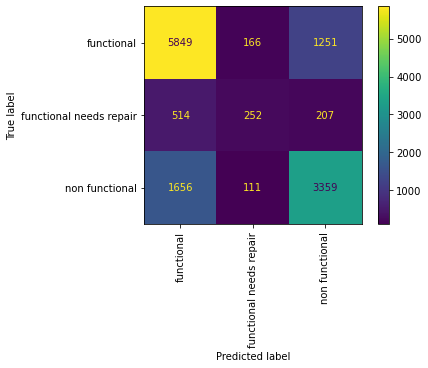

In [63]:
plot_confusion_matrix(rfc, X_test_nums_scaled, y_test, xticks_rotation='vertical');

In [64]:
model_predictions(rfc, X_test_nums_scaled, y_test)

The model correctly predicts 80.5% of the funtional wells.
The model correctly predicts 25.9% of the funtional-needs-repair wells.
The model correctly predicts 65.53% of the non-functional wells.


This inital model that only contains numerical data is severly overfitting the data. The next model will need to tune some hyperparameters to reduce the gap between the training and testing data. Our log loss has been decreased from the dummy classifer, but there is still room for improvement

### Tuning some hyperparameters to see if the model can be improved

No categorial colums have yet been introduced.

In [11]:
pipline_1 = Pipeline([('ss', StandardScaler()), ('rfc', RandomForestClassifier())])

In [12]:
pipline_1.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()), ('rfc', RandomForestClassifier())],
 'verbose': False,
 'ss': StandardScaler(),
 'rfc': RandomForestClassifier(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'rfc__bootstrap': True,
 'rfc__ccp_alpha': 0.0,
 'rfc__class_weight': None,
 'rfc__criterion': 'gini',
 'rfc__max_depth': None,
 'rfc__max_features': 'auto',
 'rfc__max_leaf_nodes': None,
 'rfc__max_samples': None,
 'rfc__min_impurity_decrease': 0.0,
 'rfc__min_impurity_split': None,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 2,
 'rfc__min_weight_fraction_leaf': 0.0,
 'rfc__n_estimators': 100,
 'rfc__n_jobs': None,
 'rfc__oob_score': False,
 'rfc__random_state': None,
 'rfc__verbose': 0,
 'rfc__warm_start': False}

In [13]:
params_1 = {
    'rfc__max_depth': list(range(5,50,5)),
    'rfc__min_samples_leaf': list(range(5,50,5)),
    'rfc__n_estimators': list(range(25,500,25)),
}

In [14]:
rs_1 = RandomizedSearchCV(pipline_1, params_1, n_jobs=-2, verbose=3, n_iter=10)

rs_1.fit(X_train_nums, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:  1.8min finished


RandomizedSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   n_jobs=-2,
                   param_distributions={'rfc__max_depth': [5, 10, 15, 20, 25,
                                                           30, 35, 40, 45],
                                        'rfc__min_samples_leaf': [5, 10, 15, 20,
                                                                  25, 30, 35,
                                                                  40, 45],
                                        'rfc__n_estimators': [25, 50, 75, 100,
                                                              125, 150, 175,
                                                              200, 225, 250,
                                                              275, 300, 325,
                                                              350, 375, 4

In [15]:
print('The train score for the random search with some hyperparameter tuning is',
      round(rs_1.score(X_train_nums, y_train), 4))
print('')
print('The test score for the random search with some hyperparameter tuning is',
      round(rs_1.score(X_test_nums, y_test), 4))

The train score for the random search with some hyperparameter tuning is 0.7658

The test score for the random search with some hyperparameter tuning is 0.6999


In [16]:
rs_1.best_params_

{'rfc__n_estimators': 125, 'rfc__min_samples_leaf': 10, 'rfc__max_depth': 30}

In [17]:
log_loss_rfc = cross_val_score(rs_1, X_train_nums_scaled, y_train, scoring='neg_log_loss', n_jobs = -2, verbose=1, cv = 2)
log_loss_rfc = -log_loss_rfc.mean()
print('Log Loss:', log_loss_rfc)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Log Loss: 0.6974265036213974


[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:  1.9min finished


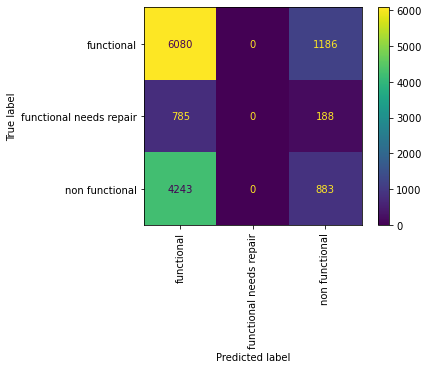

In [67]:
plot_confusion_matrix(rs_1, X_test_nums_scaled, y_test, xticks_rotation='vertical');

In [68]:
model_predictions(rs_1, X_test_nums_scaled, y_test)

The model correctly predicts 83.68% of the funtional wells.
The model correctly predicts 0.0% of the funtional-needs-repair wells.
The model correctly predicts 17.23% of the non-functional wells.


# Model 1

This is he first model that will contain the categorical colums, there will be no hyperparameter tuning done yet. 

In [82]:
X_train_nums = X_train.select_dtypes(exclude = object)

X_train_cat = X_train.select_dtypes('object')

In [83]:
numerical_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
                
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'))
])


In [84]:
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train)

OneHotEncoder(handle_unknown='ignore')

In [85]:
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
], verbose=True, n_jobs=-1)

In [86]:
model_pipe = imbPipeline(steps=[
    ('trans', trans),
    ('smote', SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(verbose=1, n_jobs=-2))
])

In [87]:
model_pipe.fit(X_train, y_train)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   55.5s finished


Pipeline(steps=[('trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'num_private', 'region_code',
       'district_code', 'population', 'construction_year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoin

In [88]:
model_pipe.score(X_train, y_train)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.2s finished


0.9945878538471131

In [89]:
model_pipe.score(X_test, y_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


0.7851103628881406

In [90]:
cv_1 = cross_val_score(model_pipe, X_train, y_train, scoring='neg_log_loss', n_jobs = -2, verbose = 3, cv = 2)
-cv_1.mean()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   41.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   41.3s finished


0.8551601593542469

In [91]:
cv_1 = cross_val_score(model_pipe, X_test, y_test, scoring='neg_log_loss', n_jobs = -2, verbose = 3, cv = 2)
-cv_1.mean()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:    7.8s finished


0.8693381383613343

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.1s finished


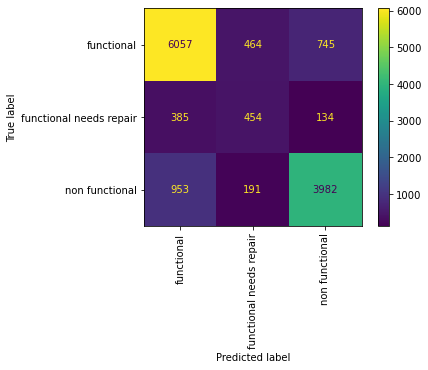

In [92]:
plot_confusion_matrix(model_pipe, X_test, y_test, xticks_rotation='vertical');

In [93]:
model_predictions(model_pipe, X_test, y_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


The model correctly predicts 83.36% of the funtional wells.
The model correctly predicts 46.66% of the funtional-needs-repair wells.
The model correctly predicts 77.68% of the non-functional wells.


This first model is a significant improvement from the first Random Forst Classifer model. The train score increase by $0.0736$. However, the model is still significanly overfitting and that will need to be reduced by hyperparameter tuning. 

The log loss also improved from $1.005$ with the first model with only numeric colums to $0.8861$ with all colums included. This was an improvement of $0.1188$.

# Hyperparameter Tuning

## The first model

Since the training scores are severly overfitting the test scores in the data I will first limit the max depth of the tree. This should certainly help to limit overfitting. I will leave other hyperparamters in their default state for now.

In [28]:
model_pipe_1 = imbPipeline(steps=[
    ('trans', trans),
    ('smote', SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(verbose=1, n_jobs=-2))
])

In [29]:
model_pipe_1.get_params()

{'memory': None,
 'steps': [('trans', ColumnTransformer(n_jobs=-1,
                     transformers=[('numerical',
                                    Pipeline(steps=[('ss', StandardScaler())]),
                                    Index(['gps_height', 'longitude', 'latitude', 'num_private', 'region_code',
          'district_code', 'population', 'construction_year'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('ohe',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
          'permit', 'extraction_type', 'management', 'payment', 'water_quality',
          'quantity', 'source', 'waterpoint_type'],
         dtype='object'))],
                     verbose=True)),
  ('rfc', RandomForestClassifier(n_jobs=-2, verbose=1))],
 'verbose': False,
 'tran

In [30]:
params = {
    'rfc__max_depth': list(range(10,100,10))
}

In [31]:
gs_1 = GridSearchCV(model_pipe_1, params, n_jobs=-2, verbose=3, cv = 2)
gs_1.fit(X_train, y_train)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-2)]: Done  12 out of  18 | elapsed:  1.4min remaining:   43.2s
[Parallel(n_jobs=-2)]: Done  18 out of  18 | elapsed:  1.8min finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   12.0s finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'num_private', 'region_code',
       'district_code', 'population', 'construction_year'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unk...'))]),
                            

In [32]:
gs_1.score(X_train, y_train)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9119341563786009

In [33]:
gs_1.score(X_test, y_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


0.8007482229704452

In [34]:
cv_1 = cross_val_score(model_pipe_1, X_train, y_train, scoring='neg_log_loss', n_jobs = -2, verbose = 3, cv = 2)
-cv_1.mean()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   14.1s finished


0.8162920792421597

In [35]:
cv_1 = cross_val_score(model_pipe_1, X_test, y_test, scoring='neg_log_loss', n_jobs = -2, verbose = 1, cv = 2)
-cv_1.mean()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:    3.8s finished


0.8407004274634774

In [36]:
gs_1.best_params_

{'rfc__max_depth': 20}

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


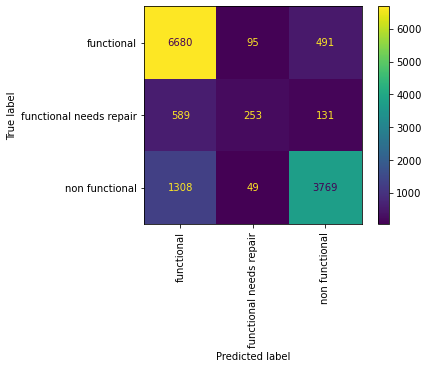

In [80]:
plot_confusion_matrix(gs_1, X_test, y_test, xticks_rotation='vertical');

In [81]:
model_predictions(gs_1, X_test, y_test)

The model correctly predicts 91.94% of the funtional wells.
The model correctly predicts 26.0% of the funtional-needs-repair wells.
The model correctly predicts 73.53% of the non-functional wells.


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


## Model 2

In this second iteration I will still change max depth, but will also change the number of estimators to see how a change in the number of trees would effect the accuracy score. I will also use criterion to see if it has any effect on the score of the model.

In [94]:
model_pipe_2 = imbPipeline(steps=[
    ('trans', trans),
    ('smote', SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(verbose=1, n_jobs=-2))
])

In [95]:
params = {
    'rfc__max_depth': list(range(10,100,10)),
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__n_estimators': list(range(50,250,50))   
}

In [96]:
gs_2 = GridSearchCV(model_pipe_2, params, n_jobs=-2, verbose=3, cv = 2)
gs_2.fit(X_train, y_train)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-2)]: Done 144 out of 144 | elapsed: 39.9min finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:  1.4min finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'num_private', 'region_code',
       'district_code', 'population', 'construction_year'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unk...
       'permit', 'extraction_type'

In [97]:
gs_2.score(X_train, y_train)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.4s finished


0.9946127946127946

In [98]:
gs_2.score(X_test, y_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished


0.7856341189674523

In [99]:
cv_2 = cross_val_score(model_pipe_2, X_train, y_train, scoring='neg_log_loss', n_jobs = -2, verbose = 1, cv = 2)
-cv_2.mean()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   31.1s finished


0.8787449916362378

In [100]:
cv_2 = cross_val_score(model_pipe_2, X_test, y_test, scoring='neg_log_loss', n_jobs = -2, verbose = 1, cv = 2)
-cv_2.mean()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:    6.4s finished


0.8764125920938577

In [101]:
gs_2.best_params_

{'rfc__criterion': 'gini', 'rfc__max_depth': 50, 'rfc__n_estimators': 200}

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished


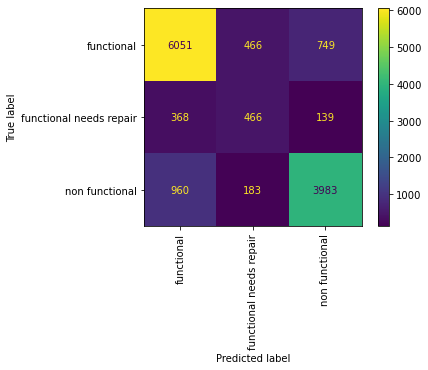

In [102]:
plot_confusion_matrix(gs_2, X_test, y_test, xticks_rotation='vertical');

In [103]:
model_predictions(gs_2, X_test, y_test)
# The model correctly predicts 91.69% of the funtional wells.
# The model correctly predicts 27.85% of the funtional-needs-repair wells.
# The model correctly predicts 73.78% of the non-functional wells.

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s


The model correctly predicts 83.28% of the funtional wells.
The model correctly predicts 47.89% of the funtional-needs-repair wells.
The model correctly predicts 77.7% of the non-functional wells.


[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished


## Model 3

In [47]:
model_pipe_3 = imbPipeline(steps=[
    ('trans', trans),
    ('smote', SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(verbose=1, n_jobs=-2))
])

In [48]:
params = {
    'rfc__max_depth': list(range(10,100,10)),
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__n_estimators': list(range(100,250,50)),
    'rfc__min_samples_leaf': list(range(2,16,2)),
    'rfc__min_samples_split': list(range(2,16,2)),
}

In [49]:
gs_3 = GridSearchCV(model_pipe_3, params, n_jobs=-2, verbose=3, cv = 1)
gs_3.fit(X_train, y_train)

Fitting 2 folds for each of 11664 candidates, totalling 23328 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-2)]: Done 498 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-2)]: Done 1138 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-2)]: Done 1554 tasks      | elapsed: 48.7min
[Parallel(n_jobs=-2)]: Done 2034 tasks      | elapsed: 74.5min
[Parallel(n_jobs=-2)]: Done 2578 tasks      | elapsed: 98.5min
[Parallel(n_jobs=-2)]: Done 3186 tasks      | elapsed: 138.9min
[Parallel(n_jobs=-2)]: Done 3858 tasks      | elapsed: 170.9min
[Parallel(n_jobs=-2)]: Done 4594 tasks      | elapsed: 218.0min
[Parallel(n_jobs=-2)]: Done 5394 tasks      | elapsed: 261.7min
[Parallel(n_jobs=-2)]: Done 6258 tasks      | elapsed: 308.8min
[Parallel(n_jobs=-2)]: Done 7186 tasks    

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'num_private', 'region_code',
       'district_code', 'population', 'construction_year'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unk...
      dtype='object'))],
         

In [50]:
gs_3.score(X_train, y_train)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.3s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.3s finished


0.8945255019329094

In [51]:
gs_3.score(X_test, y_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished


0.8028432472876917

In [53]:
cv_3 = cross_val_score(model_pipe_3, X_train, y_train, scoring='neg_log_loss', n_jobs = -2, verbose = 1, cv = 2)
-cv_3.mean()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   15.6s finished


0.7988410238913739

In [54]:
cv_3 = cross_val_score(model_pipe_3, X_test, y_test, scoring='neg_log_loss', n_jobs = -2, verbose = 1, cv = 2)
-cv_3.mean()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:    2.8s finished


0.8566245992336383

In [55]:
gs_3.best_params_

{'rfc__criterion': 'entropy',
 'rfc__max_depth': 80,
 'rfc__min_samples_leaf': 2,
 'rfc__min_samples_split': 4,
 'rfc__n_estimators': 200}

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished


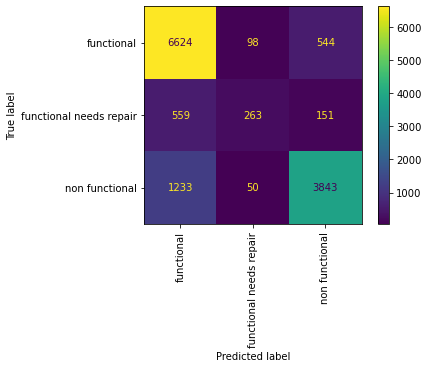

In [76]:
plot_confusion_matrix(gs_3, X_test, y_test, xticks_rotation='vertical');

In [77]:
model_predictions(gs_3, X_test, y_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished


The model correctly predicts 91.16% of the funtional wells.
The model correctly predicts 27.03% of the funtional-needs-repair wells.
The model correctly predicts 74.97% of the non-functional wells.


# Model 3 With SMOTE

In [106]:
model_pipe_4 = imbPipeline(steps=[
    ('trans', trans),
    ('smote', SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(verbose=1, n_jobs=-2, 
                                   criterion = 'entropy',
                                   max_depth = 80,
                                   min_samples_leaf = 2,
                                   min_samples_split = 4,
                                   n_estimators = 200))])

In [108]:
model_pipe_4.fit(X_train, y_train)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:   53.1s finished


Pipeline(steps=[('trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'num_private', 'region_code',
       'district_code', 'population', 'construction_year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['in...'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='obj

In [109]:
model_pipe_4.score(X_train, y_train)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.4s finished


0.9023818431225838